# Apply svm on amazon fine food reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

Id ProductId - unique identifier for the product UserId - unqiue identifier for the user ProfileName HelpfulnessNumerator - number of users who found the review helpful HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not Score - rating between 1 and 5 Time - timestamp for the review Summary - brief summary of the review Text - text of the review

# [1]. Reading Data

# [1.1] Loading the data

The dataset is available in two forms

.csv file SQLite Database In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [238]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


import os

In [239]:
# using SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-review/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.shape

Number of data points in our data (100000, 10)


(100000, 10)

# [2] Exploratory Data Analysis

# [2.1] Data Cleaning: Deduplication¶

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [240]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [241]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [242]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

Observation:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [243]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [244]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [245]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# [3] Preprocessing

# [3.1]. Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [246]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'after', 'again', 'had', 'this', 'between', "hasn't", 'does', 'doing', 'myself', "shan't", "shouldn't", 'not', 'her', "mightn't", "aren't", 'she', 'it', 'they', 'to', 're', "you'll", 'them', 'no', 'or', 'under', "haven't", 'and', 'their', 'here', 'its', 'can', 'above', "needn't", 'but', 'hers', "won't", 'o', 'those', 'each', 'which', 'for', 'own', 'both', 'below', 'nor', 'do', 'now', 'through', "weren't", "mustn't", 'in', 'haven', 'being', 'only', 'until', 'an', 'then', 'ours', 'was', 'be', 'your', 'by', 'if', 'before', 'hadn', 'theirs', 'such', 'how', 'other', "wouldn't", 's', 'shan', 'won', 'out', 'should', 'from', 'have', 'yourselves', "she's", 'why', 'some', 'down', 't', 'ourselves', 'there', "don't", "couldn't", "hadn't", 'ma', 'once', 'his', 'don', 'with', 'where', 'few', 'my', 'aren', 'is', 'a', 'will', "you've", 'herself', 'were', 'weren', 'wasn', 'same', 'the', "that'll", 'when', 'all', 'yourself', 'doesn', "isn't", 'him', 'yours', 'himself', "it's", "you'd", "didn't", 'that'

In [247]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1


In [248]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (87773, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infest fruitfli liter everywher fli around kit...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate star...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish read review make purchas basic cardsotck ...


In [249]:
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
time_sorted_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",noth product bother link top page buy use chew...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff doesnt rot gum tast good go buy gum...
61299,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan...",youv never tri kona coffe aloha island definit...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",fresh lime underappreci joy kitchen squirt lim...
38889,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...,groceri store kind coffe laid one tri tast lik...
38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,1,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...,blend one starbuck gentler blend like tast sta...
10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...,chatchi favorit afternoon treat becam mysteri ...


In [250]:
# Getting the Labels i.e the Score out of the dataframe.
y = time_sorted_data['Score']

# Removing the Labels i.e the Score Column from the dataframe as we wont need it to train a KNN.
x = time_sorted_data.drop(columns='Score',inplace=False)
#x.head()
y
x

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",noth product bother link top page buy use chew...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff doesnt rot gum tast good go buy gum...
61299,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan...",youv never tri kona coffe aloha island definit...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",fresh lime underappreci joy kitchen squirt lim...
38889,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...,groceri store kind coffe laid one tri tast lik...
38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...,blend one starbuck gentler blend like tast sta...
10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...,chatchi favorit afternoon treat becam mysteri ...


In [433]:
x_train = x.iloc[0:61441]
y_train = y.iloc[0:61441]
x_test =x.iloc[61441:87773]
y_test = y.iloc[61441:87773]
x_test
print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)
y_test.shape
x_train[0:10]

Training Set -  (61441, 10)
Test Set -  (26332, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",noth product bother link top page buy use chew...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff doesnt rot gum tast good go buy gum...
61299,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan...",youv never tri kona coffe aloha island definit...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",fresh lime underappreci joy kitchen squirt lim...
38889,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...,groceri store kind coffe laid one tri tast lik...
38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...,blend one starbuck gentler blend like tast sta...
10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...,chatchi favorit afternoon treat becam mysteri ...


# [4] FEATURIZATION

# 4.1 BAG OF WORDS

In [338]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect1 = CountVectorizer()
bow_train= count_vect1.fit_transform(x_train['CleanedText'].values)

bow_train.shape


(61441, 28686)

In [339]:
from sklearn.preprocessing import StandardScaler

train = StandardScaler(with_mean = False).fit_transform(bow_train)
train.shape


(61441, 28686)

In [340]:
bow_test = count_vect1.transform(x_test['CleanedText'].values)


bow_test.shape

(26332, 28686)

In [341]:
from sklearn.preprocessing import StandardScaler

test = StandardScaler(with_mean = False).fit_transform(bow_test)
test.shape

(26332, 28686)

# 4.2 TF-IDF

In [256]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_train = tfidf_vect.fit_transform(x_train['CleanedText'].values)
tfidf_train.shape

(61441, 28686)

In [257]:
from sklearn.preprocessing import StandardScaler

train_tfidf = StandardScaler(with_mean = False).fit_transform(tfidf_train)
train_tfidf.shape


(61441, 28686)

In [258]:
tfidf_test = tfidf_vect.transform(x_test['CleanedText'].values)

tfidf_test.shape

(26332, 28686)

In [259]:
from sklearn.preprocessing import StandardScaler

test_tfidf = StandardScaler(with_mean = False).fit_transform(tfidf_test)
test_tfidf.shape


(26332, 28686)

# 4.3 AVERAGE WORD2VEC

In [422]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in x_train['CleanedText'].values:
    list_of_sent.append(sent.split())
    
list_of_test=[]
for sent in x_test['CleanedText'].values:
    list_of_test.append(sent.split())
    

In [423]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [424]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
#print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9898


In [264]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

61441
50


In [265]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

26332
50


In [268]:
from sklearn.preprocessing import StandardScaler

train_word = StandardScaler(with_mean = False).fit_transform(sent_vectors)
print(len(train_word))
train_word.shape

61441


(61441, 50)

In [269]:
from sklearn.preprocessing import StandardScaler

test_word = StandardScaler(with_mean = False).fit_transform(test_vectors)
print(len(test_word))
test_word

26332


array([[-0.19376175, -0.69025872, -1.89637301, ...,  0.09193358,
        -1.55538305,  0.04606734],
       [-0.56475355,  1.83204288,  0.17409912, ..., -2.04631525,
        -0.87711412,  1.67586975],
       [-0.14888779,  0.05226733, -0.00865196, ...,  0.59803481,
         0.52811738,  0.08847463],
       ...,
       [-1.16041553, -0.46602256, -1.08258248, ..., -1.26125331,
        -2.06413101, -0.29600422],
       [ 0.08620092, -2.03765913, -2.44140254, ..., -0.52688453,
        -1.01622787, -2.66321105],
       [-0.8192099 ,  1.87186004,  0.16063805, ...,  0.24204187,
        -0.1625018 ,  2.0329433 ]])

# Applying SVM

# [5.1] Linear SVM

# [5.1.1] Applying Linear SVM on BOW, SET 1

In [364]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve,auc,roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

In [366]:
Alpha = [0.0001, 0.01, 1, 100, 10000]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, cv=3,scoring='roc_auc',n_jobs = -1,pre_dispatch=2) 
model.fit(train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = model.best_estimator_.alpha
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
The optimal value of C(1/lambda) is :  1


In [367]:
sgd = SGDClassifier(alpha=optimal_C, n_jobs=-1)
sgd.fit(train,y_train)
predictions = sgd.decision_function(test)
predictions1=sgd.predict(test)
normalized = (predictions-min(predictions))/(max(predictions)-min(predictions))
acc = roc_auc_score(y_test,normalized)
print(acc)
predictions1


0.8732755224233317


array([1, 1, 1, ..., 1, 1, 1])

# PLOTTING CONFUSION MATRIX

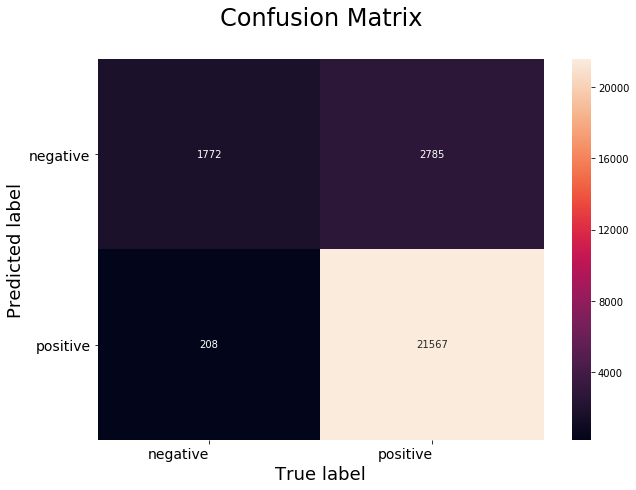

In [368]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


# PLOTTING ROC

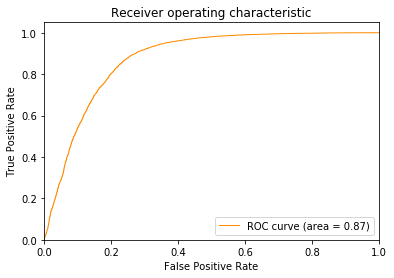

In [369]:
from sklearn.metrics import roc_curve, auc
#probs = sgd.predict_proba(test)
#preds = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test,normalized)
#fpr2, tpr2, thresholds2 = roc_curve(predictions2, y_train)
roc_auc = auc(fpr, tpr)
#roc_auc1 = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.plot(fpr2, tpr2, color='black', lw=1, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [347]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
X=model.grid_scores_
X


[mean: 0.83023, std: 0.00706, params: {'alpha': 0.0001},
 mean: 0.84562, std: 0.00736, params: {'alpha': 0.01},
 mean: 0.86010, std: 0.01327, params: {'alpha': 1},
 mean: 0.52387, std: 0.01005, params: {'alpha': 100},
 mean: 0.51943, std: 0.01004, params: {'alpha': 10000}]

In [348]:
model.cv_results_['mean_test_score']

array([0.83022724, 0.84562125, 0.8600982 , 0.52387284, 0.51942943])

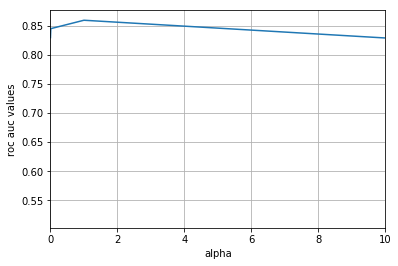

In [349]:
plt.plot(Alpha, list(model.cv_results_['mean_test_score']))
plt.xlabel("alpha")
plt.ylabel("roc auc values")
plt.xlim(0,10)
plt.grid()

# Feature importance

# Top 10 important features for positive class

In [350]:
S=sgd.coef_.ravel().argsort()[::-1]
M=sgd.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(count_vect1.get_feature_names())
L=feature_names[S]

Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O


,features,score
0,great,0.109331
1,love,0.102558
2,good,0.076947
3,best,0.069200
4,delici,0.056905
5,favorit,0.048344
6,excel,0.046452
7,perfect,0.043277
8,nice,0.041850
9,price,0.039829


# Top 10 important features for negative class

In [353]:
S=sgd.coef_.ravel().argsort()
M=sgd.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(count_vect1.get_feature_names())
L=feature_names[S]

Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O


,features,score
0,disappoint,-0.045838
1,worst,-0.039703
2,terribl,-0.035324
3,horribl,-0.035030
4,return,-0.034952
5,aw,-0.034499
6,wast,-0.034058
7,bad,-0.032756
8,threw,-0.032110
9,unfortun,-0.026673


# [5.2] RBF SVM

# [5.2.1] Applying RBF SVM on BOW, SET 1

In [284]:
# We will collect different 40K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:40000])
print("Shape of my_final dataframe : ",my_final.shape)
my_final.head(50)

Shape of my_final dataframe :  (40000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
90169,98118,B0030VJ70K,A3A9U6L4UF50S8,Mommyof4,0,0,1,1326844800,The BEST,"I have a four year old, three year old and 18 ...",four year old three year old month old love bu...
97619,106066,B001E5DYEE,A3ERIN04FRSLFC,"knitmom ""Sock crazy""",0,0,1,1252713600,Best Dried Cherries,I LOVE these dried cherries from the cherry ca...,love dri cherri cherri capit travers citi mich...
16255,17755,B000Z978SS,AHRP5S5H6ES4V,"G. Cook ""Accapella freak""",2,3,0,1233878400,Powdered and granulated not interchangeable!,"I bought this expecting the ""powdered"" form as...",bought expect powder form specifi end pay prod...
22740,24878,B007729RBC,A3AZT5F1PFC4WA,LoMann,0,0,1,1345593600,non- GMO Xylitol. Great for sugar free baking.,Xylitol is an all natural alternative to chemi...,xylitol natur altern chemic sugar free sweeten...
36403,39571,B00028P3CK,A5YMJUIG1T2IP,"Paul Valadez ""PaulyV""",1,4,1,1235001600,VERY FLEXIBLE,IN THE PAST I HAVE HAD TROUBLE WITH OTHER COMP...,past troubl compani would requir signatur deli...
58678,63726,B002IEZJMA,A38Z8ZXX1BPFRL,"Melodie ""2kidznus""",0,2,1,1338595200,Treat yourself for 45 calories....Nice caffein...,I liked this coffee drink iced. A great after...,like coffe drink ice great afternoon boost cal...
46518,50603,B000W5N2D0,A3RCCE0IS4YIAS,"James Alexander II ""beagle 1174""",0,0,1,1284336000,Review,Product was excellent really seemd to help my ...,product excel realli seemd help dog howev pric...
88918,96770,B001ELL4F4,A1G0U73UI2570T,John Martinsen,0,0,1,1325203200,Awesome flavor,"Wonderful taste, better price than the store a...",wonder tast better price store fast ship defin...
21143,23118,B004ZIER34,AG4U11RFDY7LU,Virginia Campbell,0,0,1,1311897600,smooth cup of coffee,This French Roast coffee blend from Puroast is...,french roast coffe blend puroast deep smooth d...
50828,55180,B001GVIUXQ,AO2Z6SCI5TDBJ,S. E. Fanning,7,18,0,1210291200,My pets hate Newman's products,I've bought Newman's own products a couple of ...,ive bought newman product coupl time dog cat s...


In [285]:
my_final_sorted = my_final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
my_final_sorted

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",noth product bother link top page buy use chew...
61299,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan...",youv never tri kona coffe aloha island definit...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",fresh lime underappreci joy kitchen squirt lim...
38889,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...,groceri store kind coffe laid one tri tast lik...
62127,67497,B0000D9N7U,AQFIH82DRPMW,Patrick O'Brien,26,26,1,1068940800,Try It!,"If you've never had real Swiss fondue, you're ...",youv never real swiss fondu your realli miss s...
39671,43130,B0000W2SZS,A2BETN6Y2DEFZ1,Catnip,11,11,1,1069459200,"Imparts wonderful, light flavor to dishes","I discovered these oils years ago, bought one ...",discov oil year ago bought one flavor thunders...
48952,53177,B002UUJ590,A2IF5C0I5BH11F,Kala,17,18,1,1070668800,Jelly Belly Overload!,"I'm a huge fan of Jelly Belly jelly beans, so ...",huge fan jelli belli jelli bean realli enjoy g...
86599,94282,B0000CNU2Q,A1IU7S4HCK1XK0,Joanna Daneman,14,14,1,1072656000,"Essential for Tonkatsu, etc",This is the Japanese version of breadcrumb (pa...,japanes version breadcrumb portugues panko use...


In [287]:
# Getting the Labels i.e the Score out of the dataframe.
y1 = my_final_sorted['Score']

# Removing the Labels i.e the Score Column from the dataframe as we wont need it to train a KNN.
x1 = my_final_sorted.drop(columns='Score',inplace=False)
#x.head()



In [289]:
x_train1 = x1.iloc[0:28000]
y_train1 = y1.iloc[0:28000]
x_test1 =x1.iloc[28000:40000]
y_test1 = y1.iloc[28000:40000]
x_test1
print ("Training Set - ", x_train1.shape)
print ("Test Set - ", x_test1.shape)
y_test.shape

Training Set -  (28000, 10)
Test Set -  (12000, 10)


(26332,)

In [290]:
#BoW (Bag of Words Vectorizer)
count_vect = CountVectorizer(min_df = 10, max_features = 500) 
X_train_vec1 = count_vect.fit_transform(x_train1['CleanedText'].values)
X_test_vec1 = count_vect.transform(x_test1['CleanedText'].values)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec1.get_shape())
print("the number of unique words :", X_train_vec1.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized1 = sc.fit_transform(X_train_vec1)
X_test_vec_standardized1 = sc.transform(X_test_vec1)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (28000, 500)
the number of unique words : 500


In [291]:
from sklearn.svm import SVC
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized1, y_train1)
print("Model with best parameters :\n",model.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The optimal value of C(1/lambda) is :  1


In [294]:
svc = SVC(C=optimal_C,probability=True)
svc.fit(X_train_vec_standardized1,y_train1)
predictions1 = svc.predict(X_test_vec_standardized1)
predictions=svc.predict_probaba(X_test_vec_standardized1)

auc=roc_auc_score(predictions[:,1])

0.8970454517807389


# Plotting confusion matrix

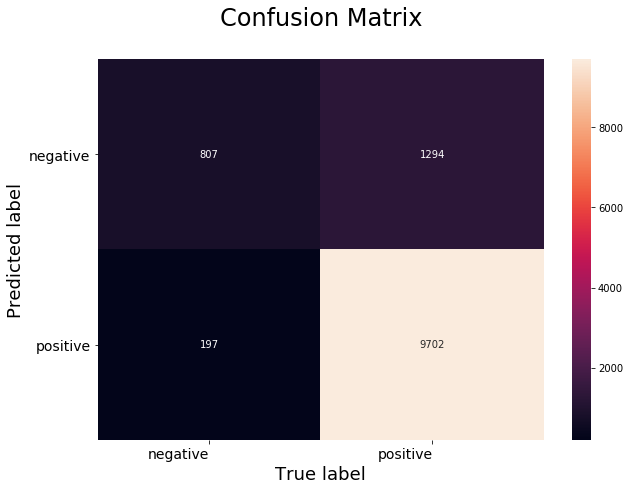

In [303]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


#    PLOTTING ROC

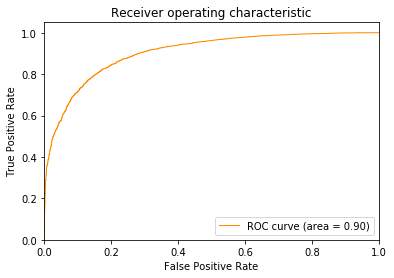

In [392]:
from sklearn.metrics import roc_curve, auc
#probs = sgd.predict_proba(test)
#preds = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test1,predictions[:,1])
#fpr2, tpr2, thresholds2 = roc_curve(predictions2, y_train)
roc_auc = auc(fpr, tpr)
#roc_auc1 = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.plot(fpr2, tpr2, color='black', lw=1, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [393]:
L=model.grid_scores_
L

[mean: 0.82675, std: 0.01005, params: {'C': 0.0001},
 mean: 0.88923, std: 0.00689, params: {'C': 0.01},
 mean: 0.89751, std: 0.00613, params: {'C': 1},
 mean: 0.89995, std: 0.00553, params: {'C': 100},
 mean: 0.89995, std: 0.00553, params: {'C': 10000}]

here we can see that when C=1 it bas the highest mean scores

# [5.1.2] Applying Linear SVM on TF-1DF, SET 2

In [370]:
Alpha = [0.0001, 0.01, 1, 100, 10000]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, cv=3,scoring='roc_auc',n_jobs = -1,pre_dispatch=2) 
grid=model.fit(train_tfidf, y_train)
print("Model with best parameters :\n",grid.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = grid.best_estimator_.alpha
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
The optimal value of C(1/lambda) is :  1


In [371]:
sgd = SGDClassifier(alpha=optimal_C, n_jobs=-1)
sgd.fit(train_tfidf,y_train)
predictions = sgd.decision_function(test_tfidf)
predictions1=sgd.predict(test_tfidf)
normalized = (predictions-min(predictions))/(max(predictions)-min(predictions))
acc = roc_auc_score(y_test,normalized)
print(acc)
predictions1


0.9038766465439552


array([1, 1, 1, ..., 1, 1, 1])

# PLOTTING CONFUSION MATRIX

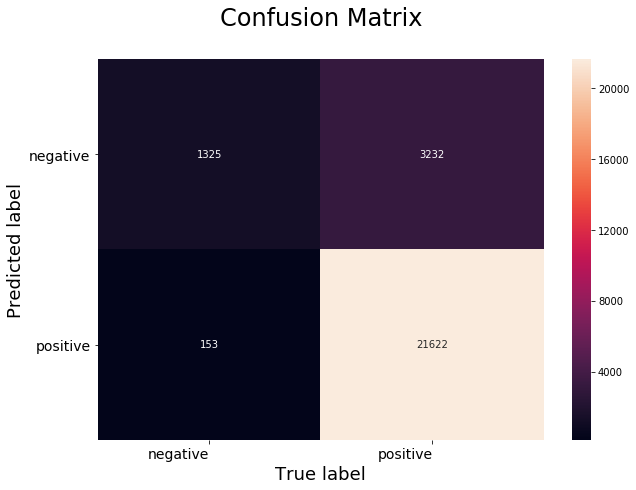

In [372]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


# PLOTTING ROC

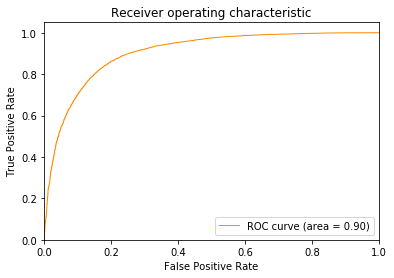

In [373]:
from sklearn.metrics import roc_curve, auc
#probs = sgd.predict_proba(test)
#preds = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test,normalized)
#fpr2, tpr2, thresholds2 = roc_curve(predictions2, y_train)
roc_auc = auc(fpr, tpr)
#roc_auc1 = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.plot(fpr2, tpr2, color='black', lw=1, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [374]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
X=model.grid_scores_
X


[mean: 0.83901, std: 0.00500, params: {'alpha': 0.0001},
 mean: 0.85302, std: 0.00816, params: {'alpha': 0.01},
 mean: 0.89875, std: 0.00942, params: {'alpha': 1},
 mean: 0.61870, std: 0.01260, params: {'alpha': 100},
 mean: 0.61870, std: 0.01260, params: {'alpha': 10000}]

In [360]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve,auc,roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

In [376]:
model.cv_results_['mean_test_score']

array([0.83900985, 0.85301894, 0.89874757, 0.6187001 , 0.61869931])

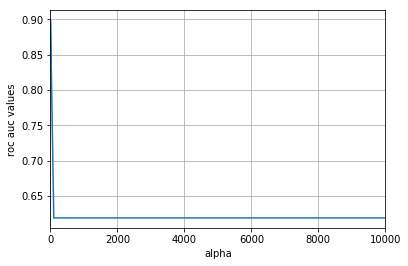

In [377]:
plt.plot(Alpha, list(grid.cv_results_['mean_test_score']))
plt.xlabel("alpha")
plt.ylabel("roc auc values")
plt.xlim(0,10000)
plt.grid()

# Top 10 important features for positive class

In [378]:
S=sgd.coef_.ravel().argsort()[::-1]
M=sgd.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(tfidf_vect.get_feature_names())
L=feature_names[S]

Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O


,features,score
0,great,0.066196
1,love,0.062759
2,good,0.053142
3,best,0.045288
4,delici,0.037159
5,nice,0.030024
6,favorit,0.029748
7,excel,0.029232
8,perfect,0.029081
9,use,0.027597


In [379]:
S=sgd.coef_.ravel().argsort()
M=sgd.coef_.ravel()[S]
X=M[0:20]
feature_names=np.array(tfidf_vect.get_feature_names())
L=feature_names[S]

Y=L[0:20]
O=pd.DataFrame({'features': Y,
 'score': X})
O

,features,score
0,worst,-0.039065
1,disappoint,-0.038725
2,return,-0.037261
3,aw,-0.033588
4,horribl,-0.032792
5,terribl,-0.032350
6,threw,-0.031499
7,wast,-0.031271
8,refund,-0.027284
9,disgust,-0.026112


# [5.2.2] APPLYING RBF SVM ON TF-IDF SET2

In [381]:
#BoW (Bag of Words Vectorizer)
tfidf_vect1 = TfidfVectorizer(min_df = 10, max_features = 500) 
tfidf_train1 = tfidf_vect1.fit_transform(x_train1['CleanedText'].values)
tfidf_test1 = tfidf_vect1.transform(x_test1['CleanedText'].values)

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
tfidf_train_vec_standardized1 = sc.fit_transform(tfidf_train1)
tfidf_test_vec_standardized1 = sc.transform(tfidf_test1)
tfidf_train_vec_standardized1.shape

(28000, 500)

In [383]:
from sklearn.svm import SVC
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
grid=model.fit(tfidf_train_vec_standardized1, y_train1)
print("Model with best parameters :\n",grid.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = grid.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The optimal value of C(1/lambda) is :  100


In [386]:
svc = SVC(C=optimal_C,probability=True)
svc.fit(tfidf_train_vec_standardized1,y_train1)
predictions1 = svc.predict(tfidf_test_vec_standardized1)
predictions=svc.predict_proba(tfidf_test_vec_standardized1)



In [395]:
acc = roc_auc_score(y_test1,predictions[:,1])
print(acc)

0.9042229180116608


# PLOTTING CONFUSION MATRIX

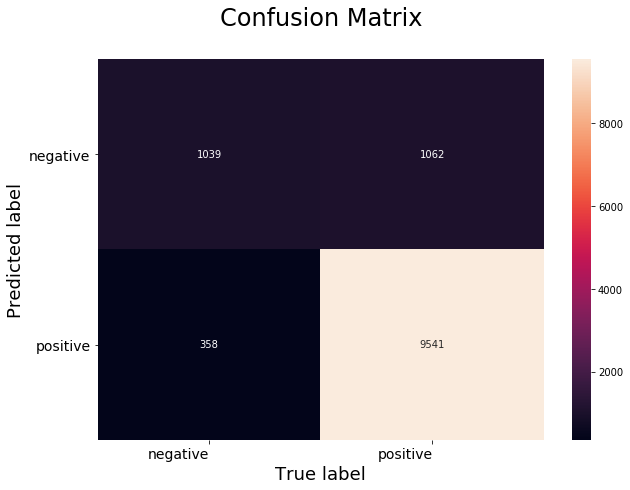

In [396]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


# PLOTTING ROC

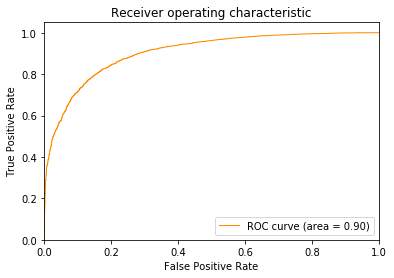

In [394]:
from sklearn.metrics import roc_curve, auc
#probs = sgd.predict_proba(test)
#preds = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test1,predictions[:,1])
#fpr2, tpr2, thresholds2 = roc_curve(predictions2, y_train)
roc_auc = auc(fpr, tpr)
#roc_auc1 = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.plot(fpr2, tpr2, color='black', lw=1, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [402]:
L=grid.grid_scores_
L

[mean: 0.82675, std: 0.01005, params: {'C': 0.0001},
 mean: 0.88923, std: 0.00689, params: {'C': 0.01},
 mean: 0.89751, std: 0.00613, params: {'C': 1},
 mean: 0.89995, std: 0.00553, params: {'C': 100},
 mean: 0.89995, std: 0.00553, params: {'C': 10000}]

WE CAN SEE HERE WE HAVE THE HIGHEST MEAN SCORES WHEN WE HAVE OPTIMAL C WHICH IS 100

# [5.1.3] APPLYING LINEAR SVM ON WORD2VEC

In [403]:
Alpha = [0.0001, 0.01, 1, 100, 10000]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, cv=3,scoring='roc_auc',n_jobs = -1,pre_dispatch=2) 
model.fit(train_word, y_train)
print("Model with best parameters :\n",model.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = model.best_estimator_.alpha
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
The optimal value of C(1/lambda) is :  0.01


In [404]:
sgd = SGDClassifier(alpha=optimal_C, n_jobs=-1)
sgd.fit(train_word,y_train)
predictions = sgd.decision_function(test_word)
predictions1=sgd.predict(test_word)
normalized = (predictions-min(predictions))/(max(predictions)-min(predictions))
acc = roc_auc_score(y_test,normalized)
print(acc)



0.8993935674340103


# Plotting confusion matrix

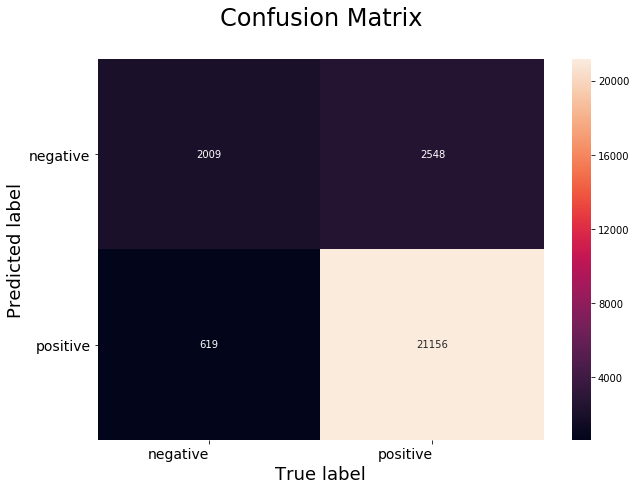

In [406]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


# plotting roc

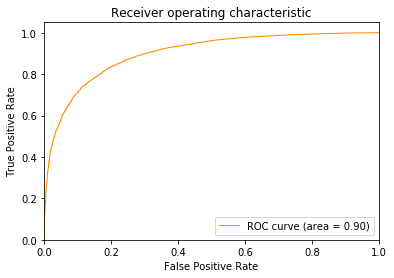

In [414]:
from sklearn.metrics import roc_curve, auc
#probs = sgd.predict_proba(test)
#preds = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test,normalized)
#fpr2, tpr2, thresholds2 = roc_curve(predictions2, y_train)
roc_auc = auc(fpr, tpr)
#roc_auc1 = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.plot(fpr2, tpr2, color='black', lw=1, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [411]:
A=model.grid_scores_
A


[mean: 0.85137, std: 0.01544, params: {'alpha': 0.0001},
 mean: 0.89717, std: 0.00558, params: {'alpha': 0.01},
 mean: 0.89249, std: 0.00794, params: {'alpha': 1},
 mean: 0.62444, std: 0.00594, params: {'alpha': 100},
 mean: 0.62444, std: 0.00594, params: {'alpha': 10000}]

Here we can see that we have the highest scores when we have the optimal C which is 0.01

# 5.2.3 Apply Rbf svm on word2vec 

In [434]:
x_train2=x_train[0:28000]
y_train2=y_train[0:28000]
x_test2=x_test[28000:40000]
y_test2=y_test[28000:40000]
x_train2.shape


(28000, 10)

In [439]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in x_train1['CleanedText'].values:
    list_of_sent.append(sent.split())
    
list_of_test=[]
for sent in x_test1['CleanedText'].values:
    list_of_test.append(sent.split())
    

In [440]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model1=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [441]:
w2v_words1 = list(w2v_model1.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words1))
#print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7111


In [442]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec1 = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec1 += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec1 /= cnt_words
    sent_vectors1.append(sent_vec1)
print(len(sent_vectors1))


28000


In [443]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_test: # for each review/sentence
    sent_vec1 = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec1 += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec1 /= cnt_words
    test_vectors1.append(sent_vec1)
print(len(test_vectors1))
print(len(test_vectors1[0]))

12000
50


In [444]:
from sklearn.preprocessing import StandardScaler

train_word1 = StandardScaler(with_mean = False).fit_transform(sent_vectors1)
print(len(train_word1))
train_word1.shape

28000


(28000, 50)

In [445]:
from sklearn.preprocessing import StandardScaler

test_word1 = StandardScaler(with_mean = False).fit_transform(test_vectors1)
print(len(test_word1))
test_word1.shape

12000


(12000, 50)

In [455]:
from sklearn.svm import SVC
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(SVC(), tuned_parameters,scoring='roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(train_word1, y_train1)
print("Model with best parameters :\n",grid.best_estimator_)
#print("Auc  of the model : ",model.score(test, y_test))

optimal_C = grid.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)


Model with best parameters :
 SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The optimal value of C(1/lambda) is :  100


In [447]:
svc = SVC(C=optimal_C,probability=True)
svc.fit(train_word1,y_train1)
predictions1 = svc.predict(test_word1)
predictions=svc.predict_proba(test_word1)
acc = roc_auc_score(y_test1,predictions[:,1])
print(acc)

0.8394966217338671


# plotting confusion matrix

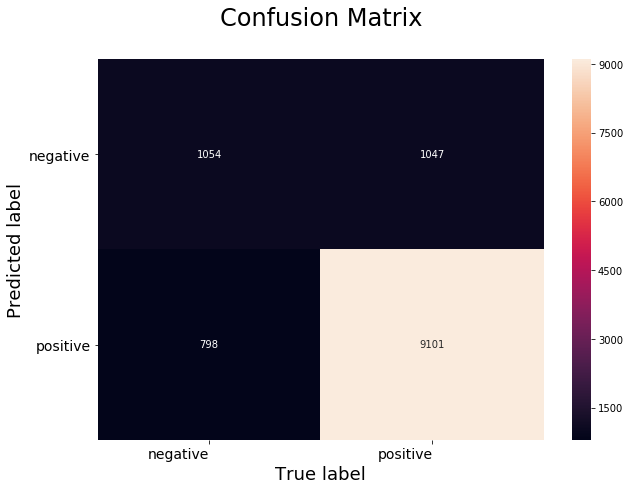

In [450]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, predictions1), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


# plotting roc curve

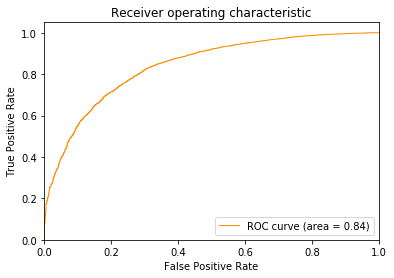

In [452]:
from sklearn.metrics import roc_curve, auc
#probs = sgd.predict_proba(test)
#preds = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test1,predictions[:,1])
#fpr2, tpr2, thresholds2 = roc_curve(predictions2, y_train)
roc_auc = auc(fpr, tpr)
#roc_auc1 = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.plot(fpr2, tpr2, color='black', lw=1, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [456]:
A=model.grid_scores_
A


[mean: 0.86897, std: 0.00523, params: {'C': 0.0001},
 mean: 0.88235, std: 0.00318, params: {'C': 0.01},
 mean: 0.88566, std: 0.00311, params: {'C': 1},
 mean: 0.84022, std: 0.00434, params: {'C': 100},
 mean: 0.82717, std: 0.00429, params: {'C': 10000}]

In [461]:
from pandas import DataFrame
Cars = {'Model': ['Linear svm on bow','Rbf svm on bow','Linear svm on tfidf','Rbf svm on tfidf','Linear svm on word2vec','Rbf svm on word2vec'],
        'Optimal_C': [1,1,1,100,0.01,100],'test auc':[0.873,0.897,0.903,0.904,0.899,0.839]
        }
df = DataFrame(Cars, columns= ['Model', 'Optimal_C','test auc'])
df

,Model,Optimal_C,test auc
0,Linear svm on bow,1.00,0.873
1,Rbf svm on bow,1.00,0.897
2,Linear svm on tfidf,1.00,0.903
3,Rbf svm on tfidf,100.00,0.904
4,Linear svm on word2vec,0.01,0.899
5,Rbf svm on word2vec,100.00,0.839
